### Analysis by: Faraz Rahman	  
### Date : 10/24/2023

### Title: Land Cover Classification Using Landsat Imagery in Google Earth Engine

#### Introduction:
This notebook provides a detailed process of conducting land cover classification using Landsat imagery using the Google Earth Engine platform and the estimating biomass for the location of interest. This notebook can be read in 3 important parts. 

Part 1 of this notebook deals with relevant data collection processes that is required to conduct the analysis i.e., defining the helper functions required to retrieve Landsat data for a specified geographic location, date range, and cloud cover threshold, defining functions for creating interactive map for visualizing Landsat imagery, and collecting the training data required for building a classification model.

Part 2 of this notebook utilizes the data collected in Part 1 and builds a classification model to identify landcover classes and creates a visualization to identify changes in land cover from one class to other. 

Part 3 of the notebook explores the biomass estimation techniques at a given geometry(location) using NDVI fetched from Landsat imagery and biomass data.

#### Data & Logistics:

1. Data Provided: The location data provided was a .kml file that represented the Big Coast Project area. This large polygon was then processed in QGIS to split the large polygon into small sized polygons representing the area.
2. Data Used: Out of the several split polygons, only one polygon was used to create this project. Apart from that, for creating a training sample we will require land classification data that can be used to train a Machine Learning model and assess its accuracy. In this regard, the training data was created using the "Land Cover of North America at 30 meters, 2020" created by USGS between dates "2019-01-01T00:00:00Z–2021-12-31T00:00:00" and accessed via earth engine API(https://developers.google.com/earth-engine/datasets/catalog/USGS_NLCD_RELEASES_2020_REL_NALCMS).
3. To process and estimate the biomass cover for the desired area, data from Global Ecosystem Dynamics Investigation (GEDI), was used (https://daac.ornl.gov/GEDI/guides/GEDI_L4B_Gridded_Biomass.html). This dataset provides estimates of mean aboveground biomass density (AGBD) based on observations from 2019-04-18 to 2021-08-04 for the entire globe. The dataset available was for the entire globe, barring most areas from our desired project locations. However, I did get some representative samples of data extracted that was used for estimating biomass. 

In [258]:
# Import the required libraries

import ee
import geemap
import pandas as pd
import geopandas as gpd

In [259]:
# # Authenticate and initialize the earthengine library
# # Trigger the authentication flow.
# ee.Authenticate()

# # Initialize the library.
# ee.Initialize()

### PART 1:

1. Defining the helper functions required to retrieve Landsat data for a specified geographic location.
2. Data collection processes that is required to conduct the analysis i.e., , date range, and cloud cover threshold.
3. Creating interactive map for visualizing Landsat imagery.
4. Collecting the training data required for building a classification model.

In [260]:
# Define the helper functions

def fetch_landsat_data(location: ee.Geometry, 
                       start_date: str, 
                       end_date: str, 
                       cloud_cover: int):
    """
    This function fetches the landsat data between a date range (start and end date)
    for a location and returns a landsat imagery containing bands between B1 and B7.
    :param location: desired geometric location (Point or Polygon)
    :param start_date: start date
    :param end_date: end date
    :param cloud_cover: percent of cloud cover
    :return:earth engine image collection
    """
    # Define the Landsat image collection
    landsat_image = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA'). \
        filterDate(ee.Date(start_date), ee.Date(end_date)). \
        filterBounds(location). \
        filterMetadata('CLOUD_COVER', 'less_than', cloud_cover).first(). \
        select('B[1-7]')

    print(f"The date of fetched image is {ee.Date(landsat_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()}")

    print(f"The cloud cover is {landsat_image.get('CLOUD_COVER').getInfo()}")

    return landsat_image


def create_map(location: ee.Geometry, image: ee.Image):
    """
    This function is in the context of the Google Earth Engine Python API,
    that takes in the location and image (landsat) and outputs an interactive 
    map that can be used for visualizing geospatial data and results.
    :param location: location to focus on the basemap
    :param image: landsat imagery to overlay on basemap
    :return: geemap Map object
    """
    Map = geemap.Map()
    Map.centerObject(location, 6)
    Map.addLayer(image, {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 0.4,
        'gamma': 1.4
    }, 'Landsat Composite')
    return Map

#### Data Preparation:

1. Define the area of interest i.e. one polygon from the entire area
2. Define and fetch the year of study (or model training data) and date of fetching the landsat imagery- The training year is 2020, because we have nlcd data(which is used for training labels) for the year 2020.
3. Fetch the nlcd data to create training samples.
4. Fetch the image data for prediction, which must be 2 years apart (we will take, 2022 as prediction year)

In [261]:
# 1. Define the area of interest i.e. one polygon from the entire area

# Load the required polygon dataset
split_polygons = gpd.read_file('boundary_clipped.geojson')

# extract a desired polygon from the file and assign it as a area of interest.
polygon_47 = split_polygons[split_polygons['id'] == 47]
multipolygon_string = str(polygon_47['geometry'].iloc[0])

# Extract the coordinates from the string and format them into a list of lists
coordinates = multipolygon_string.strip("MULTIPOLYGON (((").rstrip("))").split(", ")
coordinate_list = [list(map(float, point.split(" "))) for point in coordinates]

# Add the first point at the end to create a closed polygon
coordinate_list.append(coordinate_list[0])

# print(coordinate_list)

# Convert the string to earth engine Multipolygon object

aoi_47 = ee.Geometry.MultiPolygon(coordinate_list)

# aoi_47.getInfo()

In [262]:
# 2. Fetch the training year data i.e., landsat imagery from 2020 between May to August

landsat_2020 = fetch_landsat_data(location = aoi_47, 
                                   start_date = ee.Date('2020-06-01'), 
                                   end_date = ee.Date('2020-08-31'), 
                                   cloud_cover = 10)


create_map(location = aoi_47, image = landsat_2020)

The date of fetched image is 2020-07-27
The cloud cover is 7.79


Map(center=[50.205892979516676, -126.7178366678171], controls=(WidgetControl(options=['position', 'transparent…

In [263]:
# 3. Fetch the nlcd data to create training samples.

# Here we are loading the land classification data from the USGS Land Cover of North America at 30 meters, 2020 and clipping the area 47
# This will provide labels of classification 
nlcd_2020 = ee.Image('USGS/NLCD_RELEASES/2020_REL/NALCMS').select('landcover').clip(aoi_47)
Map2 = geemap.Map()
Map2.centerObject(aoi_47, 6)
Map2.addLayer(nlcd_2020, {}, 'NLCD')
Map2

Map(center=[50.205892979516676, -126.7178366678171], controls=(WidgetControl(options=['position', 'transparent…

In [264]:
# 4.Fetch the image data for prediction, which must be 2 years apart (we will take, 2022 as prediction year)

landsat_2022 = fetch_landsat_data(location = aoi_47, 
                                   start_date = ee.Date('2022-05-01'), 
                                   end_date = ee.Date('2022-08-31'), 
                                   cloud_cover = 10)


create_map(location = aoi_47, image = landsat_2022)

The date of fetched image is 2022-08-18
The cloud cover is 9.73


Map(center=[50.205892979516676, -126.7178366678171], controls=(WidgetControl(options=['position', 'transparent…

In [265]:
# 5. This is an additional step, to get another image from the year 2022 to understand some images 
# from fall time frame in the desired location.  

landsat_2022_fall = fetch_landsat_data(location = aoi_47, 
                                   start_date = ee.Date('2022-08-31'), 
                                   end_date = ee.Date('2022-12-31'), 
                                   cloud_cover = 10)


create_map(location = aoi_47, image = landsat_2022)

The date of fetched image is 2022-09-19
The cloud cover is 4.39


Map(center=[50.205892979516676, -126.7178366678171], controls=(WidgetControl(options=['position', 'transparent…

### PART 2:

#### Model Training and Testing:

In this step following tasks will take place:

1. Creating a training data set for machine learning or classification task. This step samples a specific number of points within the defined ROI from the NLCD data, including both pixel values and geometries, which can be used for training and validating machine learning models for land cover classification or other geospatial analyses.
2. Creat 3 classification models(CART, SVM and RandomForest) and compare the results. 

In [266]:
# Make the training dataset.
points = nlcd_2020.sample(
    **{
        'region': aoi_47,
        'scale': 30,
        'numPixels': 5000,
        'seed': 0,
        'geometries': True,  
    }
)
print(points.size().getInfo())
print(points.first().getInfo())

4199
{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-126.58430450087165, 49.74523604477778]}, 'id': '0', 'properties': {'landcover': 8}}


In [267]:
# Define the bands for prediction.
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Define the label which is the land cover labels.
label = 'landcover'

# Split the data into training and testing sets.
split = 0.7  

# Create a random column for each feature
points_with_random = points.randomColumn('random')

# Filter the collection based on the random number and the split ratio.
training_set = points_with_random.filter(ee.Filter.lt('random', split))
testing_set = points_with_random.filter(ee.Filter.gte('random', split))


# Overlay the points on the imagery to get training.
training = landsat_2020.select(bands).sampleRegions(
    **{'collection': training_set, 'properties': [label], 'scale': 30}
)

# Train a CART classifier with default parameters.
# trained = ee.Classifier.smileCart().train(training, label, bands)

# trained = ee.Classifier.smileRandomForest(10).train(training, label, bands)

# print(training.first().getInfo())



# Train Random Forest
rf_model = ee.Classifier.smileRandomForest(10).train(training, label, bands)

# Train SVM
svm_model = ee.Classifier.libsvm().train(training, label, bands)

# Train CART (Decision Tree)
cart_model = ee.Classifier.smileCart().train(training, label, bands)

In [268]:
# Make predictions on the testing set.
testing = landsat_2020.select(bands).sampleRegions(
    collection=testing_set,
    properties=[label],
    scale=30
)
# Make predictions
rf_predictions = testing.classify(rf_model)
svm_predictions = testing.classify(svm_model)
cart_predictions = testing.classify(cart_model)

# Calculate accuracy for each model
rf_accuracy = rf_predictions.errorMatrix(label, 'classification').accuracy().getInfo()
svm_accuracy = svm_predictions.errorMatrix(label, 'classification').accuracy().getInfo()
cart_accuracy = cart_predictions.errorMatrix(label, 'classification').accuracy().getInfo()

# Print the accuracy of each model
print('Random Forest Accuracy:', rf_accuracy)
print('SVM Accuracy:', svm_accuracy)
print('CART Accuracy:', cart_accuracy)

Random Forest Accuracy: 0.820979020979021
SVM Accuracy: 0.779020979020979
CART Accuracy: 0.7538461538461538


#### Prediction of landcover on 2022 images

Since Random Forest has the most accuracy, we will go with it as our final model for predictions classify and visualize the images from 2022 and also images from 2022 fall. 

In [269]:
# Classify the first image from 2020 with the same bands used for training.
classify_2020 = landsat_2020.select(bands).classify(rf_model)

# Classify the image from 2022 with the same bands used for training.
classify_2022 = landsat_2022.select(bands).classify(rf_model)

# Classify the image from 2022 fall with the same bands used for training.
classify_2022_fall = landsat_2022_fall.select(bands).classify(rf_model)

#### Visualize the results:
In this step we will visualize the result, but first we need to get the bands and color palettes that are similar to what is used for classifying in nlcd data.

In [270]:
class_values = nlcd_2020.get('landcover_class_values').getInfo()
class_values

class_palette = nlcd_2020.get('landcover_class_palette').getInfo()
class_palette

['033e00',
 '939b71',
 '196d12',
 '1fab01',
 '5b725c',
 '6b7d2c',
 'b29d29',
 'b48833',
 'e9da5d',
 'e0cd88',
 'a07451',
 'bad292',
 '3f8970',
 '6ca289',
 'e6ad6a',
 'a9abae',
 'db2126',
 '4c73a1',
 'fff7fe']

In [271]:
# Visualize the classification of 2020 map
landcover_2020 = classify_2020.set('classification_class_values', class_values)
landcover_2020 = landcover_2020.set('classification_class_palette', class_palette)
Map2020 = geemap.Map()
Map2020.centerObject(aoi_47, 8)
Map2020.addLayer(landcover_2020, {}, 'Land cover')
Map2020

Map(center=[50.205892979516676, -126.7178366678171], controls=(WidgetControl(options=['position', 'transparent…

In [272]:
# Visualize the classification of 2022 map
landcover_2022 = classify_2022.set('classification_class_values', class_values)
landcover_2022 = landcover_2022.set('classification_class_palette', class_palette)
Map2022 = geemap.Map()
Map2022.centerObject(aoi_47, 8)
Map2022.addLayer(landcover_2022, {}, 'Land cover')
Map2022

Map(center=[50.205892979516676, -126.7178366678171], controls=(WidgetControl(options=['position', 'transparent…

In [273]:
# Visualize the classification of 2022 fall map
landcover_2022_fall = classify_2022_fall.set('classification_class_values', class_values)
landcover_2022_fall = landcover_2022_fall.set('classification_class_palette', class_palette)
Map2022_fall = geemap.Map()
Map2022_fall.centerObject(aoi_47, 8)
Map2022_fall.addLayer(landcover_2022_fall, {}, 'Land cover')
Map2022_fall

Map(center=[50.205892979516676, -126.7178366678171], controls=(WidgetControl(options=['position', 'transparent…

#### Detect Landcover change from 2020 to 2022:
In this step we will focus on visualizing the land cover change using Google Earth Engine. Here, we will create a binary change image. It computes element-wise inequality between the land cover images for the two years. The resulting change_image will have pixel values of 1 where there's a change and 0 where there's no change between 2020 and 2022. The white area represents no change and pink area represents land cover change between 2020 and 2022.

In [274]:
# Load classification of land cover images for 2020 and 2022
# Create a binary change image
change_image = landcover_2022.neq(landcover_2020)

# Visualize the change image
Map_lcd = geemap.Map()
Map_lcd.centerObject(aoi_47, 8)
change_palette = ['#FFFFFF', '#FFC0CB']
Map_lcd.addLayer(change_image, {'min': 0, 'max': 1, 'palette': change_palette}, 'Land Cover Change')

# Display the map
Map_lcd.centerObject(change_image)

Map_lcd

Map(center=[50.205892979516676, -126.7178366678171], controls=(WidgetControl(options=['position', 'transparent…

### PART 3: BIOMASS ESTIMATION

This section of the notebook explores the biomass estimation at a given geometry(location) and builds upon the data gathered from the previous steps. The area for which biomass estimation is being done is the area of interest (aoi_47). This location is a small part(polygon) of the .kml file that represented the Big Coast Project area. 

#### Methodology:

The methodology used to come up with biomass estimation is to utilize NDVI (Normalized Difference Vegetation Index) to detect above ground biomass for a particular area/region. However, there isn't a simple and universally applicable formula that directly relates biomass to NDVI  because the relationship between NDVI and biomass is highly complex and context-specific. The relationship can vary depending on factors such as vegetation type, ecosystem, climate, and land use. To find specific formulas or relationships for the area of interest, I refered few research papers that have studied such relationships(between NDVI and Carbon Biomass or Aboveground biomass) for a specific ecosystem or region (i.e. in India). Using my academic access via Carnegie Mellon University, I was able to go through 2 such research papers that established relationships between Carbon Biomass and NDVI. The first paper, concluded that there is an exponential relationship between Mean NDVI values of all vegetation types and Carbon Storage in Mg/ha (Thakur et.al, 2021). 

The second paper I refered established a linear relation between NDVI and aboveground biomass in t/ha for forests consisting of four essential conifers including Blue Pine/Kail, Himalayan Cedar/Deodar , Fir , and Spruce (Wani et.al, 2021). However, one thing to note was that different forest type had different relationship equation with NDVI, and that further confirmed that, it is important to gather the ground truth biomass data to come up with an unique equation to assess the aboveground biomass of a particular area. 

Based on the common approach used at the two refered research papers and the free available data by NASA, my approach to solve this problem at this point is to use regression model to estimate aboveground biomass density from NDVI values. 

1. Data Used: To process and estimate the biomass cover for the desired area, data from Global Ecosystem Dynamics Investigation (GEDI), was used [https://daac.ornl.gov/GEDI/guides/GEDI_L4B_Gridded_Biomass.html]. This dataset provides estimates of mean aboveground biomass density (AGBD) based on observations from 2019-04-18 to 2021-08-04 for the entire globe. The dataset available was for the entire globe, barring most areas from our desired project locations. However, I did get some representative samples of data extracted that was used for estimating biomass. The data was in .tiff raster format providing biomass concentration of each pixel area for a point location. This dataset was huge(for the entire world) and was processed using QGIS to come up with sample points and corresponding biomass from the Northern America region. This clipped data containing point location and biomass was further cleaned and converted into a geojson file format and committed to the repository for further use.

2. The next step was to fetch the NDVI values of these locations for which we already have biomass density and create a regression model to come up with a formula which can be used for estimating biomass density for a location given the NDVI values. The next few steps provides this calculation and estimation.  

In [275]:
# Commenting out this portion of code, because we already ran this code and save the fetched NDVI in the repository.

# # Fetch the NDVI values of the sample location that has biomass data and make it into a comprehensive dataframe

# # Load the GeoJSON file
# gdf = gpd.read_file('roi_biomass.geojson')
# gdf = gdf.sample(n=1000, random_state=42)

# # Define the function to compute NDVI
# def compute_ndvi(lat, lon):
#     ee_point = ee.Geometry.Point(lon, lat)
#     image = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA').\
#             filterDate('2021-01-01', '2021-12-31').\
#             filterBounds(ee_point).\
#             filterMetadata('CLOUD_COVER', 'less_than', 10).first()
#     ndvi = image.normalizedDifference(['B5', 'B4'])
#     return ndvi

# ndvi_list = []

# for index, row in gdf.iterrows():
#     biomass = row['Value']
#     lat, lon = row['geometry'].y, row['geometry'].x  # Extract latitude and longitude
#     ndvi = compute_ndvi(lat, lon)
#     ndvi_value = ndvi.reduceRegion(reducer=ee.Reducer.mean(), geometry=ee.Geometry.Point(lon, lat), scale=30).get('nd')
#     ndvi_list.append({'Geometry': row['geometry'], 'Biomass Estimation': biomass, 'NDVI': ndvi_value.getInfo()})

# ndvi_df = pd.DataFrame(ndvi_list)
# ndvi_df
# # Save the result to a CSV file
# ndvi_df.to_csv('ndvi_biomass_values_2021.csv', index=False)

In [276]:
# read the ndvi data which was saved from the process above.
ndvi_df = pd.read_csv('ndvi_biomass_values_2021.csv')

In [277]:
# Top 5 rows of NDVI data fetched for our reference locations(looks like we have to remove outliers)
print(ndvi_df.head())

                                        Geometry  Biomass Estimation      NDVI
0  POINT (-123.94709543551818 51.08350914366877)           93.143745  0.057719
1  POINT (-124.70435684633853 52.17408023361821)           57.385818  0.552914
2  POINT (-125.75207468870641 49.58362393417982)          206.843491  0.667208
3  POINT (-121.67531120305709 51.93367693273643)          138.524078  0.382414
4   POINT (-125.53423236504577 51.3942514593126)           89.457939  0.770953


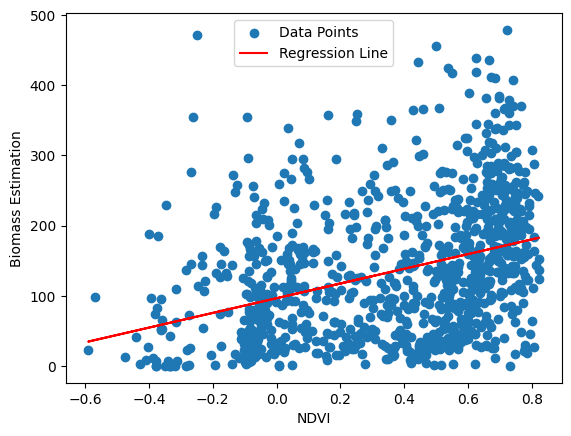

Slope: 104.89150471493751
Intercept: 96.5146241490952
R-squared (R²): 0.12839160264496946
P-value: 1.761191301073552e-31
Standard Error: 8.67714535142328


In [278]:
# Create a regression model

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# remove na values
ndvi_df = ndvi_df.dropna()
# ndvi_df = ndvi_df.sample(500)

# remove outlier values
Q1 = ndvi_df['Biomass Estimation'].quantile(0.25)
Q3 = ndvi_df['Biomass Estimation'].quantile(0.75)
IQR = Q3 - Q1

ndvi_df = ndvi_df[~(ndvi_df['Biomass Estimation'] < (Q1 - 1.5 * IQR)) | (ndvi_df['Biomass Estimation'] > (Q3 + 1.5 * IQR))]

ndvi_values = ndvi_df['NDVI'].astype(float)
biomass_values = ndvi_df['Biomass Estimation'].astype(float)

slope, intercept, r_value, p_value, std_err = stats.linregress(ndvi_values, biomass_values)

# visualize the results
plt.scatter(ndvi_values, biomass_values, label='Data Points')
plt.plot(ndvi_values, intercept + slope * ndvi_values, color='red', label='Regression Line')
plt.xlabel('NDVI')
plt.ylabel('Biomass Estimation')
plt.legend()
plt.show()


# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared (R²): {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")


#### Biomass estimation for the area of interest:

After getting the above formula that depicts the relation between NDVI and Biomass using the GEDI L4B Gridded Aboveground Biomass Density data, the next step is to get the NDVI values for our aoi. For this we will fetch the mean NDVI value of our aoi polygon for the year 2022 between June-Aug and estimate the biomass based on the formula. 

In [279]:
image = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA'). \
        filterDate(ee.Date('2022-06-01'), ee.Date('2022-08-31')). \
        filterBounds(aoi_47). \
        filterMetadata('CLOUD_COVER', 'less_than', 10).first()
ndvi_aoi_47 = image.normalizedDifference(['B5', 'B4'])

# Calculate the mean NDVI for the specified AOI
mean_ndvi = ndvi_aoi_47.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi_47,
    scale=30  
)

# Get the mean NDVI value
mean_ndvi_value = mean_ndvi.get('nd')
mean_ndvi_aoi_47 = mean_ndvi_value.getInfo()
# Print the mean NDVI value
print(f'Mean NDVI: {mean_ndvi_value.getInfo()}')

Mean NDVI: 0.5655623496812378


In [280]:
#  Applying the obtained regression formula, the biomass estimation for the aoi_47

biomass_aoi_47 = slope * mean_ndvi_aoi_47 + intercept

print(f"Applying the obtained regression formula, the biomass estimated for the aoi_47 is {biomass_aoi_47} Mg/ha between June-August")

Applying the obtained regression formula, the biomass estimated for the aoi_47 is 155.83731001727588 Mg/ha between June-August


#### References:

1. Google Earth Engine Community (GitHub).

2. Wu, Q., (2020). geemap: A Python package for interactive mapping with Google Earth Engine. The Journal of Open Source Software, 5(51), 2305. https://doi.org/10.21105/joss.02305

3. Wu, Q., Lane, C. R., Li, X., Zhao, K., Zhou, Y., Clinton, N., DeVries, B., Golden, H. E., & Lang, M. W. (2019). Integrating LiDAR data and multi-temporal aerial imagery to map wetland inundation dynamics using Google Earth Engine. Remote Sensing of Environment, 228, 1-13. https://doi.org/10.1016/j.rse.2019.04.015 (pdf | source code)

4. North American Land Change Monitoring System download webpage. www.cec.org/north-american-land-change-monitoring-system.

5. Global Ecosystem Dynamics Investigation (GEDI) was used https://daac.ornl.gov/GEDI/guides/GEDI_L4B_Gridded_Biomass.html

6. Thakur, Tarun & Patel, Digvesh & Thakur, Anita & Kumar, Anirudh & Bijalwan, Arvind & Bhat, Jahangeer & Kumar, Dr & Dobriyal, Manmohan & Kumar, Munesh & Kumar, Dr. (2021). Biomass Production Assessment in a Protected Area of Dry Tropical forest Ecosystem of India: A Field to Satellite Observation Approach. Frontiers in Environmental Science. 9. 1-17. [https://www.researchgate.net/publication/355733339_Biomass_Production_Assessment_in_a_Protected_Area_of_Dry_Tropical_forest_Ecosystem_of_India_A_Field_to_Satellite_Observation_Approach]

7. Wani, A.A., Bhat, A.F., Gatoo, A.A. et al. Assessing relationship of forest biophysical factors with NDVI for carbon management in key coniferous strata of temperate Himalayas. Mitig Adapt Strateg Glob Change 26, 1 (2021). https://doi.org/10.1007/s11027-021-09937-6. [https://link.springer.com/article/10.1007/s11027-021-09937-6]
